In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
import zipfile

zip_path = "D:/X-ray_dataset.zip"   # change name to your file

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("images")  # folder where images will be extracted

print("Extraction complete!")


Extraction complete!


In [3]:
from PIL import Image
import os

input_folder = "images"        # folder where your extracted images are
output_folder = "same_size"    # output folder
os.makedirs(output_folder, exist_ok=True)

target_size = (256, 256)       # <-- set your desired (width, height)

for file in os.listdir(input_folder):
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(input_folder, file)
        img = Image.open(img_path)

        # Resize
        img_resized = img.resize(target_size)

        # Save result
        save_path = os.path.join(output_folder, file)
        img_resized.save(save_path)

print("All images resized to", target_size)


All images resized to (256, 256)


In [4]:
from PIL import Image, ImageOps
import os

input_folder = "images"
output_folder = "same_size_padded"
os.makedirs(output_folder, exist_ok=True)

target_size = (256, 256)

for file in os.listdir(input_folder):
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        img = Image.open(os.path.join(input_folder, file))

        img = ImageOps.contain(img, target_size)          # preserve aspect ratio
        img = ImageOps.pad(img, target_size, color="white")  # add padding

        img.save(os.path.join(output_folder, file))

print("All images resized with padding to", target_size)


All images resized with padding to (256, 256)


In [1]:
from PIL import Image, ImageEnhance
import numpy as np
import os
import random

input_folder = "images"               # folder with your original images
output_folder = "augmented_images"    # output folder
os.makedirs(output_folder, exist_ok=True)

num_aug_per_image = 5  # how many augmented images to create per original


def random_rotation(img):
    # rotate between -30° and +30°, ensuring rotation ≥10°
    angle = random.choice(
        list(range(-30, -10)) + list(range(10, 30))
    )
    return img.rotate(angle, expand=True)


def horizontal_flip(img):
    if random.random() < 0.5:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img


def random_zoom(img):
    # Zoom range 80% to 120%
    zoom_factor = random.uniform(0.8, 1.2)
    w, h = img.size
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)

    img = img.resize((new_w, new_h), Image.LANCZOS)

    # Center crop or pad back to original size
    if zoom_factor > 1:  # crop
        left = (new_w - w) // 2
        top = (new_h - h) // 2
        return img.crop((left, top, left + w, top + h))
    else:  # pad
        background = Image.new("RGB", (w, h))
        left = (w - new_w) // 2
        top = (h - new_h) // 2
        background.paste(img, (left, top))
        return background


def random_shift(img):
    w, h = img.size
    max_shift_w = int(0.2 * w)  # up to 20% shift
    max_shift_h = int(0.2 * h)

    shift_x = random.randint(-max_shift_w, max_shift_w)
    shift_y = random.randint(-max_shift_h, max_shift_h)

    return img.transform(
        img.size,
        Image.AFFINE,
        (1, 0, shift_x, 0, 1, shift_y),
        fillcolor=(0, 0, 0)
    )


def random_brightness(img):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(random.uniform(0.7, 1.3))  # 30% darker/brighter


def augment_pipeline(img):
    img = random_rotation(img)
    img = horizontal_flip(img)
    img = random_zoom(img)
    img = random_shift(img)
    img = random_brightness(img)
    return img


# ---- RUN AUGMENTATION ----
for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img = Image.open(os.path.join(input_folder, filename))

        for i in range(num_aug_per_image):
            aug_img = augment_pipeline(img)
            aug_img.save(os.path.join(output_folder, f"{filename}_aug{i}.jpg"))

print("Augmentation complete!")


Augmentation complete!


In [2]:
from PIL import Image, ImageEnhance, ImageFilter
import os
import random

input_folder = "images"              # original images
output_folder = "augmented_images"   # where augmented images go
os.makedirs(output_folder, exist_ok=True)

num_aug_per_image = 5  # how many augmented versions per image

def augment_image(img):
    # Random rotation
    if random.random() < 0.5:
        angle = random.randint(-30, 30)
        img = img.rotate(angle)

    # Random flip
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() < 0.3:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)

    # Random brightness
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(random.uniform(0.6, 1.4))

    # Random color
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(random.uniform(0.6, 1.4))

    # Random blur
    if random.random() < 0.3:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 2)))

    return img

for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)

        for i in range(num_aug_per_image):
            aug = augment_image(img)
            aug.save(os.path.join(output_folder, f"{filename}_aug{i}.jpg"))

print("Augmentation complete!")


Augmentation complete!


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

generator = datagen.flow_from_directory(
    "images/",
    target_size=(256, 256),
    batch_size=1,
    class_mode=None,
    save_to_dir="augmented_images",
    save_format="jpg"
)

for i in range(100):
    next(generator)


Found 5856 images belonging to 1 classes.


In [3]:
!pip install tensorflow opencv-python matplotlib

import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(256,256,1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    bn = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    bn = layers.Conv2D(512, (3,3), activation='relu', padding='same')(bn)

    # Decoder
    u3 = layers.UpSampling2D((2,2))(bn)
    u3 = layers.concatenate([u3, c3])
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2,2))(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c5)

    u1 = layers.UpSampling2D((2,2))(c5)
    u1 = layers.concatenate([u1, c1])
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    c6 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c6)

    return Model(inputs, outputs)

model = unet_model()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, epochs=20)
model.save("lung_unet.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'train_ds' is not defined

In [5]:
import os

for root, dirs, files in os.walk(".", topdown=True):
    print(root)


.
.\.ipynb_checkpoints
.\augmented_images
.\images
.\images\chest_xray
.\images\chest_xray\test
.\images\chest_xray\test\NORMAL
.\images\chest_xray\test\PNEUMONIA
.\images\chest_xray\train
.\images\chest_xray\train\NORMAL
.\images\chest_xray\train\PNEUMONIA
.\images\chest_xray\val
.\images\chest_xray\val\NORMAL
.\images\chest_xray\val\PNEUMONIA
.\models_output
.\same_size
.\same_size_padded


Trying to load pretrained model from: https://storage.googleapis.com/lung-segmentation-models/lung_unet.h5
Could not load from https://storage.googleapis.com/lung-segmentation-models/lung_unet.h5 : File system scheme 'https' not implemented (file: 'https://storage.googleapis.com/lung-segmentation-models/lung_unet.h5')
No pretrained model loaded.
Processing 1341 images: train/NORMAL


100%|██████████| 1341/1341 [03:52<00:00,  5.77it/s]


Processing 3875 images: train/PNEUMONIA


100%|██████████| 3875/3875 [04:33<00:00, 14.14it/s]


Processing 8 images: val/NORMAL


100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


Processing 8 images: val/PNEUMONIA


100%|██████████| 8/8 [00:00<00:00, 11.32it/s]


Processing 234 images: test/NORMAL


100%|██████████| 234/234 [00:33<00:00,  6.93it/s]


Processing 390 images: test/PNEUMONIA


100%|██████████| 390/390 [00:24<00:00, 15.73it/s]


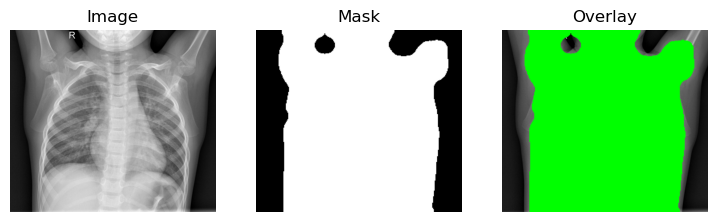

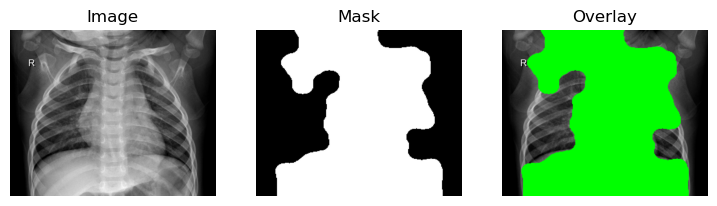

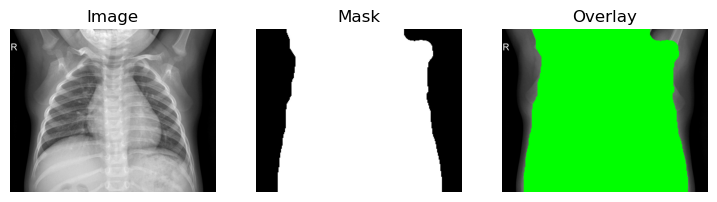

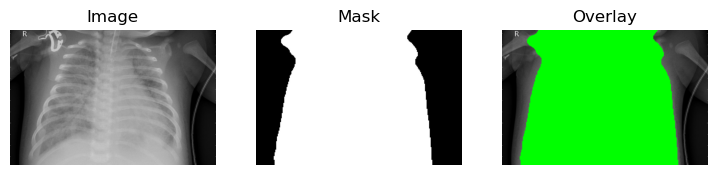

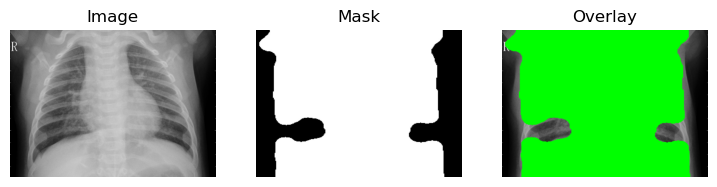

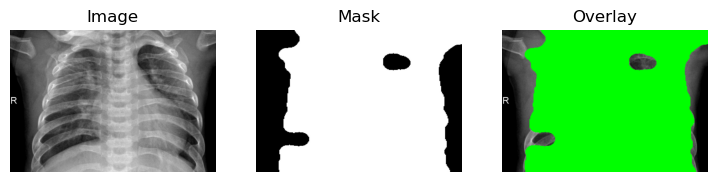

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Training: orig
Epoch 1/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7103 - loss: 0.5983   

326/326 ━━━━━━━━━━━━━━━━━━━━ 953s 3s/step - accuracy: 0.7368 - loss: 0.5820 - val_accuracy: 0.5000 - val_loss: 0.8352
Epoch 2/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 888s 3s/step - accuracy: 0.7429 - loss: 0.5756 - val_accuracy: 0.5000 - val_loss: 0.7772
Epoch 3/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 994s 3s/step - accuracy: 0.7427 - loss: 0.5775 - val_accuracy: 0.5000 - val_loss: 0.8525
Epoch 4/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 1123s 3s/step - accuracy: 0.7429 - loss: 0.5756 - val_accuracy: 0.5000 - val_loss: 0.8639
Epoch 5/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 923s 3s/step - accuracy: 0.7429 - loss: 0.5770 - val_accuracy: 0.5000 - val_loss: 0.8153
Epoch 6/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 1061s 3s/step - accuracy: 0.7429 - loss: 0.5749 - val_accuracy: 0.5000 - val_loss: 0.8499
Epoch 7/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 1081s 3s/step - accuracy: 0.7429 - loss: 0.5771 - val_accuracy: 0.5000 - val_loss: 0.8178
Epoch 8/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 924s 3s/step - accuracy: 0.7429 - loss: 0.5777 - val_accuracy: 0.

326/326 ━━━━━━━━━━━━━━━━━━━━ 1180s 3s/step - accuracy: 0.7241 - loss: 0.5895 - val_accuracy: 0.5000 - val_loss: 0.7917
Epoch 2/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.7425 - loss: 0.5761 - val_accuracy: 0.5000 - val_loss: 0.8123
Epoch 3/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.7429 - loss: 0.5777 - val_accuracy: 0.5000 - val_loss: 0.8283
Epoch 4/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.7429 - loss: 0.5789 - val_accuracy: 0.5000 - val_loss: 0.8487
Epoch 5/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.7429 - loss: 0.5756 - val_accuracy: 0.5000 - val_loss: 0.8306
Epoch 6/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.7429 - loss: 0.5765 - val_accuracy: 0.5000 - val_loss: 0.8384
Epoch 7/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.7429 - loss: 0.5764 - val_accuracy: 0.5000 - val_loss: 0.8252
Epoch 8/12
326/326 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.7429 - loss: 0.5802 - val_accuracy: 0.50

Evaluating crop
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Classification report (val):


C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         8
   PNEUMONIA       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



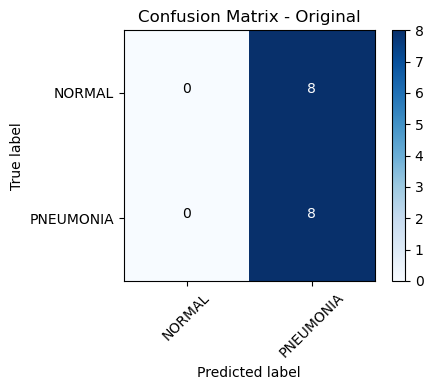

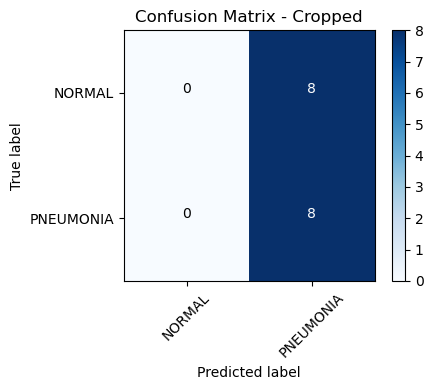

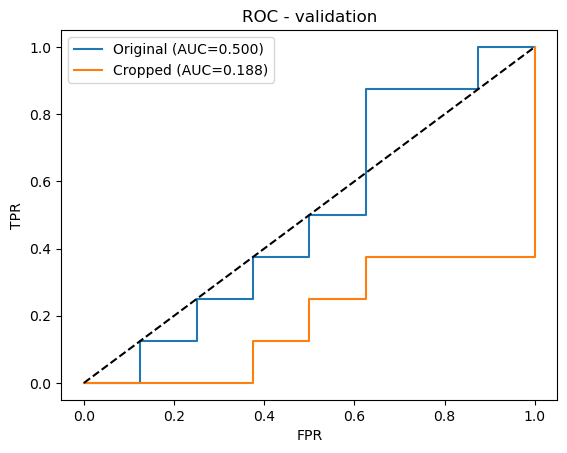

Saving classifier models to: models_output
Done. Models and report written to models_output
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
File: images/chest_xray\val\NORMAL\NORMAL2-IM-1427-0001.jpeg orig_pred: [0.2515268 0.7484732] crop_pred: [0.28865105 0.71134895]


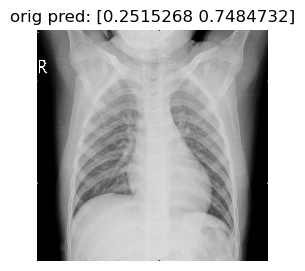

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
File: images/chest_xray\val\NORMAL\NORMAL2-IM-1430-0001.jpeg orig_pred: [0.25139615 0.7486039 ] crop_pred: [0.2887455 0.7112545]


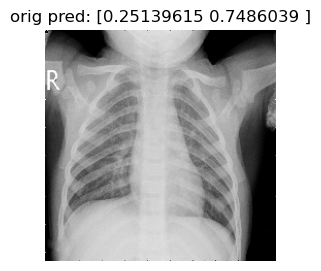

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: images/chest_xray\val\NORMAL\NORMAL2-IM-1431-0001.jpeg orig_pred: [0.25167438 0.7483256 ] crop_pred: [0.2886143 0.7113857]


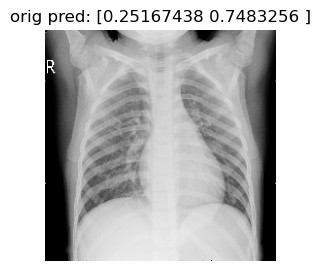

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
File: images/chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg orig_pred: [0.25129607 0.74870396] crop_pred: [0.28889474 0.7111053 ]


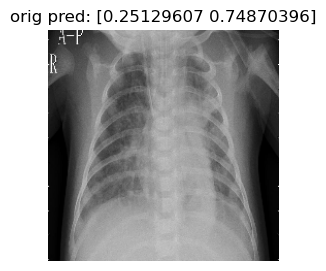

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
File: images/chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg orig_pred: [0.2511886  0.74881136] crop_pred: [0.288839 0.711161]


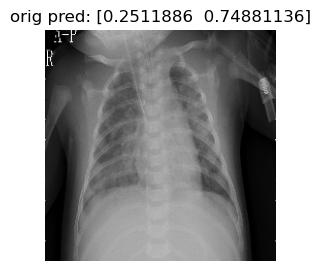

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
File: images/chest_xray\val\PNEUMONIA\person1947_bacteria_4876.jpeg orig_pred: [0.2514021  0.74859786] crop_pred: [0.28875113 0.7112488 ]


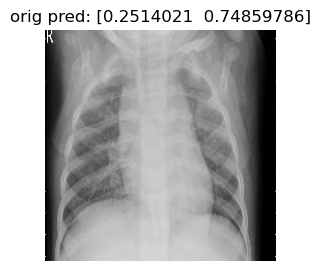

In [1]:
#Segmentation -UNet #U-Net was designed for biomedical segmentation with limited data.Provides pixel-accurate segmentation, Produces clean binary masks, Has strong clinical
#and research adoption, U-Net’s contracting path + expanding path allows:Context understanding (contracting path / encoder), Precise localization (expanding path / decode)
#This makes it extremely good at outlining lungs.
# ============================================================
# End-to-end: Auto-mask -> (optional) U-Net train -> Crop lungs ->
# Train classifiers on original vs lung-cropped -> Evaluate & visualize
# ============================================================
# Requirements:
# pip install tensorflow opencv-python scikit-image matplotlib scikit-learn tqdm
# Run in GPU for training speed (Colab: Runtime -> Change runtime type -> GPU)
# ============================================================

import os, sys, glob, shutil
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# SETTINGS (edit as needed)
# ----------------------------------------------------------------------------
BASE_IMAGES = "images/chest_xray"   # your existing dataset
OUT_MASKS = "lung_masks"            # generated masks go here
OUT_CROPS = "lung_crops"            # lung-cropped images go here
MODELS_DIR = "models_output"
IMG_SIZE = (256,256)                # segmentation input size
CLASS_IMG_SIZE = (224,224)          # classifier input size (EfficientNet default-ish)
BATCH_SIZE = 16
EPOCHS_SEG = 10    # U-Net training epochs (set low or high depending on compute)
EPOCHS_CLS = 12
SEED = 42
os.makedirs(MODELS_DIR, exist_ok=True)

# splits & class names (match your folder structure)
SPLITS = ["train","val","test"]
CLASSES = ["NORMAL","PNEUMONIA"]

# ----------------------------------------------------------------------------
# 1) Try load pretrained U-Net model (optional). If not available -> fallback.
# ----------------------------------------------------------------------------
def try_load_pretrained_unet():
    import tensorflow as tf
    pretrained_urls = [
        # placeholder academic link used earlier (may or may not be accessible)
        "https://storage.googleapis.com/lung-segmentation-models/lung_unet.h5",
        # you can add other URLs here if you have them
    ]
    for url in pretrained_urls:
        try:
            print("Trying to load pretrained model from:", url)
            model = tf.keras.models.load_model(url, compile=False)
            print("Loaded pretrained U-Net.")
            return model
        except Exception as e:
            print("Could not load from", url, ":", str(e))
    print("No pretrained model loaded.")
    return None

# ----------------------------------------------------------------------------
# 2) If pretrained not found, implement a fallback classical method (Otsu+morph)
#    to generate masks. This will create approximate lung masks.
# ----------------------------------------------------------------------------
from skimage.filters import threshold_otsu
def classical_otsu_mask_for_cxr(img_gray, img_size=IMG_SIZE):
    # img_gray: np.uint8
    im = cv2.resize(img_gray, img_size)
    blur = cv2.GaussianBlur(im, (5,5), 0)
    thr = threshold_otsu(blur)
    mask = (blur > thr).astype(np.uint8) * 255
    # morphological cleanup: close then open
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = (mask > 127).astype(np.uint8)
    return mask

# ----------------------------------------------------------------------------
# 3) Generate masks for all images (use pretrained if possible, else fallback)
# ----------------------------------------------------------------------------
import tensorflow as tf
pretrained_unet = try_load_pretrained_unet()

def gen_mask_from_model(img_gray, model, input_size=IMG_SIZE, thr=0.5):
    x = cv2.resize(img_gray, input_size).astype(np.float32)/255.0
    x = x.reshape(1, input_size[0], input_size[1], 1)
    pred = model.predict(x)[0,:,:,0]
    mask = (pred >= thr).astype(np.uint8)
    return mask

def generate_all_masks():
    # create directories
    for split in SPLITS:
        for cls in CLASSES:
            os.makedirs(os.path.join(OUT_MASKS, split, cls), exist_ok=True)

    for split in SPLITS:
        for cls in CLASSES:
            in_dir = os.path.join(BASE_IMAGES, split, cls)
            out_dir = os.path.join(OUT_MASKS, split, cls)
            files = sorted(os.listdir(in_dir))
            print(f"Processing {len(files)} images: {split}/{cls}")
            for fname in tqdm(files):
                p = os.path.join(in_dir, fname)
                img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print("Can't read:", p); continue
                h,w = img.shape
                if pretrained_unet is not None:
                    try:
                        mask_small = gen_mask_from_model(img, pretrained_unet, input_size=IMG_SIZE)
                    except Exception as e:
                        # if model fails for any reason, fallback to classical
                        mask_small = classical_otsu_mask_for_cxr(img, IMG_SIZE)
                else:
                    mask_small = classical_otsu_mask_for_cxr(img, IMG_SIZE)
                mask = cv2.resize(mask_small.astype(np.uint8), (w,h), interpolation=cv2.INTER_NEAREST)
                # save binary mask (0/255)
                out_path = os.path.join(out_dir, fname)
                cv2.imwrite(out_path, (mask * 255).astype(np.uint8))

# Run mask generation
generate_all_masks()

# ----------------------------------------------------------------------------
# 4) Quick sanity visual check (show 3 examples)
# ----------------------------------------------------------------------------
def show_examples(num=3):
    shown = 0
    for split in SPLITS:
        for cls in CLASSES:
            in_dir = os.path.join(BASE_IMAGES, split, cls)
            files = sorted(os.listdir(in_dir))[:num]
            for f in files:
                img_path = os.path.join(in_dir, f)
                mask_path = os.path.join(OUT_MASKS, split, cls, f)
                if os.path.exists(img_path) and os.path.exists(mask_path):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                    overlay[mask>127] = [0,255,0]
                    plt.figure(figsize=(9,3))
                    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img, cmap='gray'); plt.axis('off')
                    plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(mask, cmap='gray'); plt.axis('off')
                    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis('off')
                    plt.show()
                    shown += 1
                    if shown >= 6: return

show_examples()

# ----------------------------------------------------------------------------
# 5) Optional: Train U-Net on generated masks (if you want to refine segmentation)
#    Use only if you want to improve masks or if you have enough compute.
# ----------------------------------------------------------------------------
def build_unet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)):
    from tensorflow.keras import layers, Model
    inputs = layers.Input(input_shape)
    def conv_block(x, n):
        x = layers.Conv2D(n,3, padding='same', activation='relu')(x)
        x = layers.Conv2D(n,3, padding='same', activation='relu')(x)
        return x
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64);  p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPooling2D()(c4)
    bn = conv_block(p4, 512)
    u4 = layers.UpSampling2D()(bn); u4 = layers.Concatenate()([u4, c4]); c5 = conv_block(u4, 256)
    u3 = layers.UpSampling2D()(c5); u3 = layers.Concatenate()([u3, c3]); c6 = conv_block(u3, 128)
    u2 = layers.UpSampling2D()(c6); u2 = layers.Concatenate()([u2, c2]); c7 = conv_block(u2, 64)
    u1 = layers.UpSampling2D()(c7); u1 = layers.Concatenate()([u1, c1]); c8 = conv_block(u1, 32)
    out = layers.Conv2D(1,1, activation='sigmoid')(c8)
    from tensorflow.keras.models import Model
    return Model(inputs, out)

# Simple Keras Sequence to feed paired images+generated masks
from tensorflow.keras.utils import Sequence
class SegSequence(Sequence):
    def __init__(self, img_dir, mask_dir, batch_size=8, img_size=IMG_SIZE):
        self.imgs = sorted(glob.glob(os.path.join(img_dir, "*", "*")))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, "*", "*")))
        assert len(self.imgs) == len(self.masks), "Image/mask counts differ"
        self.batch_size = batch_size
        self.img_size = img_size
    def __len__(self):
        return int(np.ceil(len(self.imgs)/self.batch_size))
    def __getitem__(self, idx):
        batch_imgs = self.imgs[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_masks = self.masks[idx*self.batch_size:(idx+1)*self.batch_size]
        X = np.zeros((len(batch_imgs), self.img_size[0], self.img_size[1], 1), dtype=np.float32)
        Y = np.zeros_like(X)
        for i,(p_m,p_k) in enumerate(zip(batch_imgs, batch_masks)):
            img = cv2.imread(p_m, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size).astype(np.float32)/255.0
            m = cv2.imread(p_k, cv2.IMREAD_GRAYSCALE)
            m = cv2.resize(m, self.img_size)
            m = (m > 127).astype(np.float32)
            X[i,...,0] = img
            Y[i,...,0] = m
        return X, Y

# Train U-Net (optional)
def train_unet():
    seg_model = build_unet()
    seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    train_seq = SegSequence(os.path.join(BASE_IMAGES,"train"), os.path.join(OUT_MASKS,"train"), batch_size=8)
    val_seq = SegSequence(os.path.join(BASE_IMAGES,"val"), os.path.join(OUT_MASKS,"val"), batch_size=8)
    seg_model.fit(train_seq, validation_data=val_seq, epochs=EPOCHS_SEG)
    seg_model.save(os.path.join(MODELS_DIR, "unet_trained.h5"))
    print("Saved trained unet:", os.path.join(MODELS_DIR, "unet_trained.h5"))
    return seg_model

# Uncomment if you want to train:
# trained_unet = train_unet()

# ----------------------------------------------------------------------------
# 6) Create lung-cropped images: multiply image by mask and save to OUT_CROPS
# ----------------------------------------------------------------------------
def create_cropped_images():
    for split in SPLITS:
        for cls in CLASSES:
            in_dir = os.path.join(BASE_IMAGES, split, cls)
            mask_dir = os.path.join(OUT_MASKS, split, cls)
            out_dir = os.path.join(OUT_CROPS, split, cls)
            os.makedirs(out_dir, exist_ok=True)
            for fname in os.listdir(in_dir):
                ip = os.path.join(in_dir, fname)
                mp = os.path.join(mask_dir, fname)
                if not (os.path.exists(ip) and os.path.exists(mp)):
                    continue
                img = cv2.imread(ip, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
                mask_bin = (mask > 127).astype(np.uint8)
                # apply mask and keep original intensity within lungs
                cropped = img.copy()
                cropped[mask_bin==0] = 0
                # optionally resize to classifier size now (or do in generator)
                cropped_resized = cv2.resize(cropped, CLASS_IMG_SIZE)
                outp = os.path.join(out_dir, fname)
                cv2.imwrite(outp, cropped_resized)

create_cropped_images()

# ----------------------------------------------------------------------------
# 7) CLASSIFICATION: train EfficientNetB0 on original vs cropped images, compare.
#    We use ImageDataGenerator for augmentation and flow_from_directory.
# ----------------------------------------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import itertools

# generators for ORIGINAL images
train_gen_orig = ImageDataGenerator(rescale=1./255,
                                    rotation_range=15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True)

val_gen_orig = ImageDataGenerator(rescale=1./255)

train_flow_orig = train_gen_orig.flow_from_directory(
    os.path.join(BASE_IMAGES,"train"),
    target_size=CLASS_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

val_flow_orig = val_gen_orig.flow_from_directory(
    os.path.join(BASE_IMAGES,"val"),
    target_size=CLASS_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# generators for CROPPED images
train_gen_crop = ImageDataGenerator(rescale=1./255,
                                    rotation_range=15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True)

val_gen_crop = ImageDataGenerator(rescale=1./255)

train_flow_crop = train_gen_crop.flow_from_directory(
    os.path.join(OUT_CROPS,"train"),
    target_size=CLASS_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

val_flow_crop = val_gen_crop.flow_from_directory(
    os.path.join(OUT_CROPS,"val"),
    target_size=CLASS_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# Build classifier model (EfficientNetB0)
def build_classifier(num_classes=2, input_shape=(CLASS_IMG_SIZE[0], CLASS_IMG_SIZE[1], 3), base_trainable=False):
    base = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(base.input, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Note: our inputs are grayscale; the generator will convert to 3 channels by repeating if needed.
# To ensure 3 channels, set color_mode='rgb' in flow_from_directory (default). If your images are single-channel,
# Keras will convert them to RGB automatically.

# Train function
def train_and_evaluate(train_flow, val_flow, tag):
    model = build_classifier()
    print("Training:", tag)
    callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_DIR, f"best_{tag}.h5"),
                                                  monitor='val_accuracy', save_best_only=True, mode='max')
    history = model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS_CLS, callbacks=[callback])
    # load best
    model = tf.keras.models.load_model(os.path.join(MODELS_DIR, f"best_{tag}.h5"))
    # Evaluate on val set and test set
    print("Evaluating", tag)
    val_flow.reset()
    y_pred = model.predict(val_flow, verbose=1)
    y_true = val_flow.classes
    y_pred_labels = np.argmax(y_pred, axis=1)
    print("Classification report (val):")
    print(classification_report(y_true, y_pred_labels, target_names=val_flow.class_indices.keys()))
    cm = confusion_matrix(y_true, y_pred_labels)
    return model, history, cm, y_true, y_pred

# Train both
model_orig, hist_orig, cm_orig, y_true_orig, y_pred_orig = train_and_evaluate(train_flow_orig, val_flow_orig, "orig")
model_crop, hist_crop, cm_crop, y_true_crop, y_pred_crop = train_and_evaluate(train_flow_crop, val_flow_crop, "crop")

# ----------------------------------------------------------------------------
# 8) Visualize confusion matrices and ROC/AUC
# ----------------------------------------------------------------------------
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title); plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = list(train_flow_orig.class_indices.keys())
plot_confusion_matrix(cm_orig, class_names, title='Confusion Matrix - Original')
plot_confusion_matrix(cm_crop, class_names, title='Confusion Matrix - Cropped')
plt.show()

# ROC/AUC for val set (binary)
from sklearn.metrics import roc_curve, auc
def plot_roc(y_true, y_pred, label):
    # y_pred: probabilities shape (N,2), y_true: class indices
    y_true_bin = (np.array(y_true) == 1).astype(int)  # assuming index 1 is PNEUMONIA
    y_scores = y_pred[:,1]
    fpr, tpr, _ = roc_curve(y_true_bin, y_scores)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.3f})")

plt.figure()
plot_roc(y_true_orig, y_pred_orig, "Original")
plot_roc(y_true_crop, y_pred_crop, "Cropped")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.title("ROC - validation")
plt.show()

# ----------------------------------------------------------------------------
# 9) Save models & a short report
# ----------------------------------------------------------------------------
print("Saving classifier models to:", MODELS_DIR)
# best saved already by checkpoint
# create a basic text report
with open(os.path.join(MODELS_DIR, "report.txt"), "w") as f:
    f.write("Results summary\n")
    f.write("==== Original classifier confusion matrix ====\n")
    f.write(str(cm_orig) + "\n")
    f.write("==== Cropped classifier confusion matrix ====\n")
    f.write(str(cm_crop) + "\n")
print("Done. Models and report written to", MODELS_DIR)

# ----------------------------------------------------------------------------
# 10) Example: visualize some classified images (crops vs original)
# ----------------------------------------------------------------------------
def visualize_predictions(sample_n=6):
    # pick some val images and show predicted vs true for crop & original
    val_dir = os.path.join(BASE_IMAGES,"val")
    files = []
    for cls in CLASSES:
        files += [os.path.join(val_dir, cls, f) for f in os.listdir(os.path.join(val_dir,cls))[:sample_n//2]]
    for p in files[:sample_n]:
        fname = os.path.basename(p)
        # original prediction
        img_rgb = cv2.resize(cv2.imread(p), CLASS_IMG_SIZE)
        x = img_rgb.astype(np.float32)/255.0
        pred_o = model_orig.predict(x.reshape(1,*x.shape))[0]
        pred_c = None
        crop_path = os.path.join(OUT_CROPS, "val", os.path.basename(os.path.dirname(p)), fname)
        crop_img = None
        if os.path.exists(crop_path):
            crop_img = cv2.imread(crop_path)
            pred_c = model_crop.predict(crop_img.reshape(1,*crop_img.shape).astype(np.float32)/255.0)[0]
        print("File:", p, "orig_pred:", pred_o, "crop_pred:", pred_c)
        display_img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4,3)); plt.imshow(display_img); plt.axis('off'); plt.title(f"orig pred: {pred_o}")
        plt.show()

visualize_predictions(6)

# END


In [2]:
import os

print(os.listdir("images/chest_xray/train"))
print(os.listdir("lung_masks/train"))


['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [9]:
import os
import shutil
import random

# Corrected paths
image_dir = "images/chest_xray/"
mask_dir = "masks/chest_xray/"

output_base = "dataset_split/"
os.makedirs(output_base, exist_ok=True)

for split in ["train", "val", "test"]:
    os.makedirs(f"{output_base}/{split}/images", exist_ok=True)
    os.makedirs(f"{output_base}/{split}/masks", exist_ok=True)

# Load all images
images = sorted(os.listdir(image_dir))

# Filter only image files (avoid folders)
images = [f for f in images if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Found {len(images)} images.")

# Shuffle
random.shuffle(images)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total = len(images)
train_count = int(total * train_ratio)
val_count = int(total * val_ratio)

train_files = images[:train_count]
val_files = images[train_count:train_count + val_count]
test_files = images[train_count + val_count:]

print(f"📌 Train images: {len(train_files)}")
print(f"📌 Val images:   {len(val_files)}")
print(f"📌 Test images:  {len(test_files)}")

# Copy files
def copy_files(file_list, split):
    for file in file_list:
        shutil.copy(f"{image_dir}/{file}", f"{output_base}/{split}/images/{file}")
        shutil.copy(f"{mask_dir}/{file}", f"{output_base}/{split}/masks/{file}")

copy_files(train_files, "train")
copy_files(val_files, "val")
copy_files(test_files, "test")

print("\n✅ Dataset successfully split!")


Found 0 images.
📌 Train images: 0
📌 Val images:   0
📌 Test images:  0

✅ Dataset successfully split!


In [8]:
print(os.listdir("images/"))


['chest_xray']


In [10]:
import os
for root, dirs, files in os.walk("images", topdown=True):
    print(root, dirs, files)
for root, dirs, files in os.walk("masks", topdown=True):
    print(root, dirs, files)


images ['chest_xray'] []
images\chest_xray ['test', 'train', 'val'] []
images\chest_xray\test ['NORMAL', 'PNEUMONIA'] []
images\chest_xray\test\NORMAL [] ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0005-0001.jpeg', 'IM-0006-0001.jpeg', 'IM-0007-0001.jpeg', 'IM-0009-0001.jpeg', 'IM-0010-0001.jpeg', 'IM-0011-0001-0001.jpeg', 'IM-0011-0001-0002.jpeg', 'IM-0011-0001.jpeg', 'IM-0013-0001.jpeg', 'IM-0015-0001.jpeg', 'IM-0016-0001.jpeg', 'IM-0017-0001.jpeg', 'IM-0019-0001.jpeg', 'IM-0021-0001.jpeg', 'IM-0022-0001.jpeg', 'IM-0023-0001.jpeg', 'IM-0025-0001.jpeg', 'IM-0027-0001.jpeg', 'IM-0028-0001.jpeg', 'IM-0029-0001.jpeg', 'IM-0030-0001.jpeg', 'IM-0031-0001.jpeg', 'IM-0033-0001-0001.jpeg', 'IM-0033-0001-0002.jpeg', 'IM-0033-0001.jpeg', 'IM-0035-0001.jpeg', 'IM-0036-0001.jpeg', 'IM-0037-0001.jpeg', 'IM-0039-0001.jpeg', 'IM-0041-0001.jpeg', 'IM-0043-0001.jpeg', 'IM-0045-0001.jpeg', 'IM-0046-0001.jpeg', 'IM-0049-0001.jpeg', 'IM-0050-0001.jpeg', 'IM-0059-0001.jpeg', 'IM-0061-0001.jpeg', 'IM-00

In [12]:
import os

def find_image_folders(base):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif")
    for root, dirs, files in os.walk(base):
        # Check if this folder contains actual image files
        imgs = [f for f in files if f.lower().endswith(exts)]
        if len(imgs) > 0:
            print("📁 Folder with images:", root)
            print("   Number of images:", len(imgs))
            print("   Example files:", imgs[:5], "\n")

print("=== IMAGES ===")
find_image_folders("images")

print("\n=== MASKS ===")
find_image_folders("masks")


=== IMAGES ===
📁 Folder with images: images\chest_xray\test\NORMAL
   Number of images: 234
   Example files: ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0005-0001.jpeg', 'IM-0006-0001.jpeg', 'IM-0007-0001.jpeg'] 

📁 Folder with images: images\chest_xray\test\PNEUMONIA
   Number of images: 390
   Example files: ['person100_bacteria_475.jpeg', 'person100_bacteria_477.jpeg', 'person100_bacteria_478.jpeg', 'person100_bacteria_479.jpeg', 'person100_bacteria_480.jpeg'] 

📁 Folder with images: images\chest_xray\train\NORMAL
   Number of images: 1341
   Example files: ['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg'] 

📁 Folder with images: images\chest_xray\train\PNEUMONIA
   Number of images: 3875
   Example files: ['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg', 'person1003_bacteria_2934.jpeg'] 

📁 Folder with images: images\chest_xray\val\NORMAL
   Nu

In [14]:
import os
import shutil

source_base = "images/chest_xray/"
target_base = "dataset_split/"

splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Create output folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(target_base, split, cls), exist_ok=True)

# Copy files from original to new split folder
for split in splits:
    for cls in classes:
        src_folder = os.path.join(source_base, split, cls)
        dst_folder = os.path.join(target_base, split, cls)

        for file in os.listdir(src_folder):
            shutil.copy(os.path.join(src_folder, file),
                        os.path.join(dst_folder, file))

print("✅ Dataset copied into dataset_split/ structure")


✅ Dataset copied into dataset_split/ structure


In [15]:
import os
from PIL import Image

def verify_images(base_path):
    valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif")
    bad_files = []

    print(f"\n🔍 Scanning: {base_path}")

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if not file.lower().endswith(valid_exts):
                print(f"⚠️ Skipping non-image: {file}")
                continue

            fpath = os.path.join(root, file)
            try:
                img = Image.open(fpath)
                img.verify()   # PIL image integrity check
            except Exception as e:
                print(f"❌ Bad image: {fpath} — {e}")
                bad_files.append(fpath)

    if len(bad_files) == 0:
        print("✅ All images are valid!")
    else:
        print("\n❗ Found corrupted images:")
        for bf in bad_files:
            print("   -", bf)

# Run checks
verify_images("dataset_split/train")
verify_images("dataset_split/val")
verify_images("dataset_split/test")



🔍 Scanning: dataset_split/train
✅ All images are valid!

🔍 Scanning: dataset_split/val
✅ All images are valid!

🔍 Scanning: dataset_split/test
✅ All images are valid!


In [19]:
import os
import shutil

splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

for split in splits:
    split_path = os.path.join("dataset_split", split)
    for cls in classes:
        # Move images from dataset_split/train/images/NORMAL/* to dataset_split/train/NORMAL/
        src = os.path.join(split_path, "images", cls)
        dst = os.path.join(split_path, cls)
        if os.path.exists(src):
            for f in os.listdir(src):
                shutil.move(os.path.join(src, f), dst)
    # Remove the extra images folder
    extra_folder = os.path.join(split_path, "images")
    if os.path.exists(extra_folder):
        shutil.rmtree(extra_folder)


In [21]:
import tensorflow as tf

# Dataset paths
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/train",
    label_mode="categorical",   # changed from 'binary' to 'categorical'
    image_size=(224, 224),
    batch_size=32
).map(lambda x, y: (x / 255.0, y)).prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/val",
    label_mode="categorical",   # changed from 'binary' to 'categorical'
    image_size=(224, 224),
    batch_size=32
).map(lambda x, y: (x / 255.0, y)).prefetch(tf.data.AUTOTUNE)


Found 5216 files belonging to 3 classes.
Found 16 files belonging to 3 classes.


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import itertools

# Dataset paths
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/train", label_mode="binary", image_size=(224,224), batch_size=32
).map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_split/val", label_mode="binary", image_size=(224,224), batch_size=32
).map(lambda x, y: (x/255.0, y)).prefetch(tf.data.AUTOTUNE)

# Hyperparameter options
learning_rates = [1e-2, 1e-3]
dense_units = [128, 256]
dropout_rates = [0.3, 0.5]

# Store results
results = []

# Loop over all combinations
for lr, units, dr in itertools.product(learning_rates, dense_units, dropout_rates):
    print(f"\n🔹 Training with lr={lr}, dense_units={units}, dropout={dr}")
    
    # Build model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dr),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Train briefly (use small epochs for tuning)
    history = model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)
    
    val_acc = history.history['val_accuracy'][-1]
    results.append({'lr': lr, 'dense_units': units, 'dropout': dr, 'val_accuracy': val_acc})
    print(f"✅ Validation Accuracy: {val_acc:.4f}")

# Find best combination
best = max(results, key=lambda x: x['val_accuracy'])
print("\n🎯 Best Hyperparameters:")
print(best)


Found 5216 files belonging to 3 classes.


ValueError: When passing `label_mode="binary"`, there must be exactly 2 class_names. Received: class_names=['NORMAL', 'PNEUMONIA', 'masks']